In [1]:
from sklearn.datasets import make_classification   # para generar datos sintéticos desbalanceados
from collections import Counter 

from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt

import numpy as np
from numpy import where 



Generemos un problema de n-clases desbalanceado: 

Genera nubes de distribución normal con std=1.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html  


In [100]:
X, y = make_classification(n_samples=10000, 
                           n_features=2,  # variables de entrada
                           n_redundant=0, # si deseas features redundantes (que una sea combinación lineal de otras)   
                           n_clusters_per_class=1, 
                           weights=[0.99],  # para generar las clases desbalanceadas: [0.7,0.3]
                           flip_y=0.0,      # Introduce ruido en cada clase, cambiando su etiqueta.
                           random_state=17)

print(X.shape)
print(y.shape)

(10000, 2)
(10000,)


In [96]:
X[0:4,:]

array([[-0.51655345, -1.22440796],
       [-2.08535462, -0.48147323],
       [ 0.13775898, -1.46554355],
       [-2.31487575, -0.30636689]])

In [13]:
y[0:4]

array([0, 0, 0, 0])

In [97]:
counter = Counter(y)
print(counter)

Counter({0: 99, 1: 1})


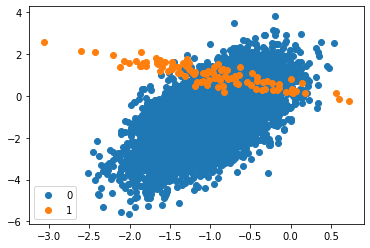

In [101]:
for label, _ in counter.items():   # label (tuple): 0 y 1
  idxs = where(y == label)[0]      # obtenemos el renglón de cada registro en la clase indicada
  plt.scatter(X[idxs, 0], X[idxs, 1], label=str(label))
  
plt.legend()
plt.show()

In [ ]:
# Modelo base:
# Todo nuevo dato de entrada lo clasificamos como de la clase del 0
# Con una exactitud del 99%  

###**Partición con estratificación con respecto a la varible de etiquetas reales:**

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, stratify=y)  

print(Counter(y_train))
print(Counter(y_test))

Counter({0: 5940, 1: 60})
Counter({0: 3960, 1: 40})


###**KFold vs StratifiedKFold vs RepeatedStratifiedKFold**

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html

In [70]:
modelo_LR = LogisticRegression(class_weight={0:1, 1:99},      # class_weight={0:1, 1:99} <--- matriz de costo
                               penalty='l2',
                               C=1.0,
                               solver='lbfgs',
                               max_iter=1000,
                               tol=0.0001)   

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

#scores = cross_val_score(modelo_LR, X_train, y_train, scoring='accuracy', cv=cv)
scores = cross_val_score(modelo_LR, X_train, y_train, scoring='recall', cv=cv)
#scores = cross_val_score(modelo_LR, X_train, y_train, scoring='precision', cv=cv)
#scores = cross_val_score(modelo_LR, X_train, y_train, scoring='f1', cv=cv)

print('Métrica : Valor promedio CV: %.2f%%' % (np.mean(scores)*100))

Métrica : Valor promedio CV: 92.78%


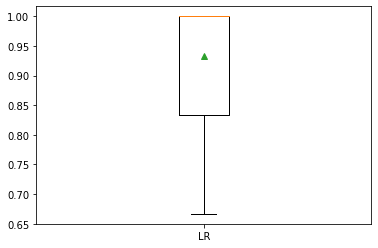

In [66]:
plt.boxplot(scores, labels=['LR'], showmeans=True)
plt.show()

In [71]:
modelo_LR.fit(X_train, y_train)

pred=modelo_LR.predict(X_test)

cm = confusion_matrix(y_test, pred)
print(cm)

t = cm.sum()
print(cm[0,0]/t, cm[0,1]/t)
print(cm[1,0]/t, cm[1,1]/t)

[[3367  593]
 [   1   39]]
0.84175 0.14825
0.00025 0.00975


In [55]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [72]:
recall_score(y_test, pred)  # del segundo renglón de cm: 5/40

0.975

In [73]:
precision_score(y_test,pred)   # de la segunda columna de cm: 5/6

0.061708860759493674

In [74]:
f1_score(y_test, pred)

0.11607142857142858

###**Métrica F2-score y F1/2-score**

In [76]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

In [81]:
def fb_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=.5)

In [82]:
modelo_LRfb = LogisticRegression(class_weight={0:1, 1:99})   # class_weight={0:1, 1:99}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

metricafb = make_scorer(fb_score)

scores = cross_val_score(modelo_LRfb, X, y, scoring=metricafb, cv=cv)

print('Métrica : Valor promedio CV: %.2f%%' % (np.mean(scores)*100))

Métrica : Valor promedio CV: 7.32%


In [83]:
modelo_LRfb.fit(X_train,y_train)

pred=modelo_LRfb.predict(X_test)

cm = confusion_matrix(y_test, pred)
print(cm)

t = cm.sum()
print(cm[0,0]/t, cm[0,1]/t)
print(cm[1,0]/t, cm[1,1]/t)

[[3367  593]
 [   1   39]]
0.84175 0.14825
0.00025 0.00975


In [84]:
f1 = fbeta_score(y_test, pred, beta=1.0)   # le da igual importancia a minimizar FN y FP
f2 = fbeta_score(y_test, pred, beta=2.0)   # le da mayor importancia a minimizar los FN
f05 = fbeta_score(y_test, pred, beta=0.5)  # le da mayor importancia a minimizar los FP

print('Result: f1=%.3f, f2=%.3f, f05=%.3f' % (f1, f2, f05))

Result: f1=0.116, f2=0.246, f05=0.076


#**KNN**

In [85]:
from sklearn.neighbors import KNeighborsClassifier

In [86]:
modelo_kNN = KNeighborsClassifier(n_neighbors=3, weights='distance')

modelo_kNN.fit(X_train, y_train)

modelo_kNN.score(X_test, y_test)

0.99125

In [87]:
pred = modelo_kNN.predict(X_test)

cm = confusion_matrix(y_test, pred)
print(cm)

[[3950   10]
 [  25   15]]


In [88]:
recall_score(y_test, pred) 

0.375

In [89]:
precision_score(y_test,pred)

0.6

In [ ]:
f1 = fbeta_score(y_test, pred, beta=1.0)   # le da igual importancia a minimizar FN y FP
f2 = fbeta_score(y_test, pred, beta=2.0)   # le da mayor importancia a minimizar los FN
f05 = fbeta_score(y_test, pred, beta=0.5)  # le da mayor importancia a minimizar los FP

print('Result: f1=%.3f, f2=%.3f, f05=%.3f' % (f1, f2, f05))

In [91]:
from sklearn import svm

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [92]:
C_range = np.logspace(start=-3, stop=2, num=4, base=10.0)
n_degree = [n for n in range(2, 8)]

param_grid = {'C':C_range, 
              'kernel':('poly','rbf','sigmoid'),  
              'degree':n_degree,
              'gamma':('scale','auto')}

modelo_SVM = svm.SVC(class_weight={0:1,1:99})   # inicializando el modelo

modelo_SVM = RandomizedSearchCV(modelo_SVM, param_distributions=param_grid, 
                                cv=3,  # Cross-Validation 
                                n_iter=10) # n_iter=total de valores seleccionados del grid

mm = modelo_SVM.fit(X_train, y_train)   # entrenamiento sobre el grid

print("Los mejores parametros son %s con un score de %0.2f"
      % (mm.best_params_, mm.best_score_))

Los mejores parametros son {'kernel': 'rbf', 'gamma': 'auto', 'degree': 6, 'C': 2.1544346900318843} con un score de 0.87


In [93]:
pred = mm.predict(X_test)

cm = confusion_matrix(y_test, pred)
print(cm)

[[3493  467]
 [   0   40]]


In [94]:
recall_score(y_test,pred)

1.0